# Computer vision: Car model detection using first party algorithms

### Set up credentials

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20181217T144959
CPU times: user 1.14 s, sys: 683 ms, total: 1.82 s
Wall time: 16.4 s


In [2]:
bucket = 'my-dl-models' # custom bucket name.
#bucket = sess.default_bucket()
prefix = 'cars'

### Choose the first party algorithm from ECR

In [3]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [4]:
import cv2
from pathlib import Path
import os
from time import time
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

### Download data from stanford public repository

In [151]:
%%capture
#!wget -nc imagenet.stanford.edu/internal/car196/cars_train.tgz # Replace with the URL to the dataset

In [149]:
#!tar -xvzf cars_train.tgz

In [150]:
#!wget -nc https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz

In [152]:
#!tar -xvzf car_devkit.tgz

In [153]:
#!pip install console_progressbar

In [6]:
import tarfile
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
from console_progressbar import ProgressBar

In [7]:
from os import listdir
from os.path import isfile, join
import os
import json

In [218]:
cars_meta = scipy.io.loadmat('devkit/cars_meta')

In [231]:
object_categories=[]
for i in cars_meta['class_names'][0]:
    object_categories.append(i[0])

In [428]:
len(os.listdir('cars_train'))

8144

In [429]:
print(object_categories)

['AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW Z4 Convertible 2012

In [102]:
print("Processing train data...")
cars_annos = scipy.io.loadmat('devkit/cars_train_annos')
annotations = cars_annos['annotations']
annotations = np.transpose(annotations)

fnames = []
class_ids = []
bboxes = []
labels = []

for annotation in annotations:
    bbox_x1 = annotation[0][0][0][0]
    bbox_y1 = annotation[0][1][0][0]
    bbox_x2 = annotation[0][2][0][0]
    bbox_y2 = annotation[0][3][0][0]
    class_id = annotation[0][4][0][0]
    labels.append('%04d' % (class_id,))
    fname = annotation[0][5][0]
    bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
    class_ids.append(class_id)
    fnames.append(fname)

labels_count = np.unique(class_ids).shape[0]
print(np.unique(class_ids))
print('The number of different cars is %d' % labels_count)

Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196


#### Data set contains 8k cars and 196 different categories

In [103]:
from PIL import Image
import os.path

In [79]:
#mkdir annotations

### Format annotations correctly (PASCAL VOC json format)

In [107]:
path='annotations/'
image_dir='./cars_train/' 
for annotation in annotations:
    bbox_xmin = annotation[0][0][0][0]
    bbox_ymin = annotation[0][1][0][0]
    bbox_xmax = annotation[0][2][0][0]
    bbox_ymax = annotation[0][3][0][0]
    class_id = annotation[0][4][0][0]
    fname = annotation[0][5][0]

    annotation_json = {
            'file': fname.split('.')[0]+'.jpg',
            'image_size': [
              {
                 'width': Image.open(image_dir+fname).size[0],
                 'height': Image.open(image_dir+fname).size[1],
                 'depth': 3
              }
           ],
           "annotations": [],
           "categories": [
              {
                 "class_id": int(class_id),
                 "name": str(class_id)
              }
           ]
        }
    annotation_json["annotations"].append({
                    "class_id": int(class_id),
                    "left": int(float(bbox_xmin)),
                    "top": int(float(bbox_ymin)),
                    "width": int(float(bbox_xmax)) - int(float(bbox_xmin)),
                    "height": int(float(bbox_ymax)) - int(float(bbox_ymin))
        })
    jsonString = json.dumps(annotation_json, indent=4)

    jsonname =  'annotations/' + os.path.splitext(fname)[0] + ".json"
    with open(jsonname, 'w') as f:
        f.write(jsonString)

In [108]:
!cat annotations/00001.json

{
    "file": "00001.jpg",
    "image_size": [
        {
            "width": 600,
            "height": 400,
            "depth": 3
        }
    ],
    "annotations": [
        {
            "class_id": 14,
            "left": 39,
            "top": 116,
            "width": 530,
            "height": 259
        }
    ],
    "categories": [
        {
            "class_id": 14,
            "name": "14"
        }
    ]
}

In [415]:
import json
from pprint import pprint

with open('annotations/00119.json') as f:
    data = json.load(f)

pprint(data)

{'annotations': [{'class_id': 147,
                  'height': 590,
                  'left': 173,
                  'top': 370,
                  'width': 1034}],
 'categories': [{'class_id': 147, 'name': '147'}],
 'file': '00119.jpg',
 'image_size': [{'depth': 3, 'height': 1026, 'width': 1368}]}


In [416]:
data['annotations'][0]

{'class_id': 147, 'left': 173, 'top': 370, 'width': 1034, 'height': 590}

### Visualize data and annotations

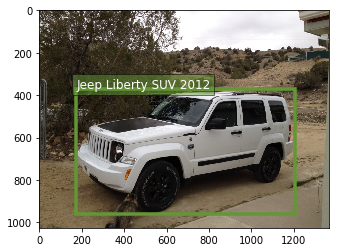

In [417]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_file='cars_train/00119.jpg'
img=mpimg.imread(img_file)
plt.imshow(img)
height = img.shape[0]
width = img.shape[1]
colors = dict()

class_name=object_categories[data['annotations'][0]['class_id']-1]
colors = (random.random(), random.random(), random.random())
rect = plt.Rectangle((data['annotations'][0]['left'], data['annotations'][0]['top']), data['annotations'][0]['width'],
                                 data['annotations'][0]['height'], fill=False,
                                 edgecolor=colors,
                                 linewidth=3.5)
plt.gca().text(data['annotations'][0]['left'], data['annotations'][0]['top'] - 2,'{:s}'.format(class_name),bbox=dict(facecolor=colors, alpha=0.5),fontsize=12, color='white')
plt.gca().add_patch(rect)
plt.show()

In [400]:
images=os.listdir('cars_train')
images.sort()

jsons=os.listdir('annotations')
jsons.sort()

num_samples=len(images)

#### Separate train and validation sets

In [394]:
import shutil
train_images=images[int(num_samples*30/100):]
val_images=images[:int(num_samples*30/100)]

train_jsons = jsons[int(num_samples*30/100):]
val_jsons = jsons[:int(num_samples*30/100)]


In [395]:
mkdir train validation train_json validation_json

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘validation’: File exists
mkdir: cannot create directory ‘train_json’: File exists
mkdir: cannot create directory ‘validation_json’: File exists


#### Upload data and define channels for input to algorithm

In [118]:
for i in train_images:
    shutil.copyfile('./cars_train/'+i, './train/'+i)
for i in val_images:
    shutil.copyfile('./cars_train/'+i, './validation/'+i)

for i in train_jsons:
    shutil.copyfile('./annotations/'+i, './train_json/'+i)
for i in val_jsons:
    shutil.copyfile('./annotations/'+i, './validation_json/'+i)
    
    

In [119]:
train_channel = prefix + '/train'
train_annotation_channel = prefix + '/train_annotation'
validation_channel = prefix + '/validation'
validation_annotation_channel = prefix + '/validation_annotation'

# Delete recursively here
sess.upload_data(path='validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='validation_json', bucket=bucket, key_prefix=validation_annotation_channel)
sess.upload_data(path='train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='train_json', bucket=bucket, key_prefix=train_annotation_channel)

's3://my-dl-models/cars/train_annotation'

In [120]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)


train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data,'train_annotation': train_annotation, 'validation': validation_data,'validation_annotation': validation_annotation}

### Set parameters for infrastructure of estimator to spin up

In [121]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.8xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

#### Set parameters for model

Object detection model with a base feature extraction model resnet-50. We are useing a pretrained model to do transfer learning and accelerate convergence to an optimal model

In [174]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=196,
                             mini_batch_size=32,
                             epochs=5,
                             learning_rate=0.01,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.01,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=len(train_images))

### Execute training job

In [ ]:
od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2019-01-09-10-43-58-355


2019-01-09 10:43:58 Starting - Starting the training job...
2019-01-09 10:44:02 Starting - Launching requested ML instances......
2019-01-09 10:45:08 Starting - Preparing the instances for training...

### Deploy model

In [176]:
%%time
import boto3
client = boto3.client('sagemaker')
import time

object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2019-01-09-20-59-51-467
INFO:sagemaker:Creating endpoint with name object-detection-2019-01-09-10-43-58-355


----------------------------------------------------------------------------------------!CPU times: user 439 ms, sys: 19.5 ms, total: 458 ms
Wall time: 7min 26s


## Let's see some results

In [143]:
ls validation/

00001.jpg  00350.jpg  00699.jpg  01048.jpg  01397.jpg  01746.jpg  02095.jpg
00002.jpg  00351.jpg  00700.jpg  01049.jpg  01398.jpg  01747.jpg  02096.jpg
00003.jpg  00352.jpg  00701.jpg  01050.jpg  01399.jpg  01748.jpg  02097.jpg
00004.jpg  00353.jpg  00702.jpg  01051.jpg  01400.jpg  01749.jpg  02098.jpg
00005.jpg  00354.jpg  00703.jpg  01052.jpg  01401.jpg  01750.jpg  02099.jpg
00006.jpg  00355.jpg  00704.jpg  01053.jpg  01402.jpg  01751.jpg  02100.jpg
00007.jpg  00356.jpg  00705.jpg  01054.jpg  01403.jpg  01752.jpg  02101.jpg
00008.jpg  00357.jpg  00706.jpg  01055.jpg  01404.jpg  01753.jpg  02102.jpg
00009.jpg  00358.jpg  00707.jpg  01056.jpg  01405.jpg  01754.jpg  02103.jpg
00010.jpg  00359.jpg  00708.jpg  01057.jpg  01406.jpg  01755.jpg  02104.jpg
00011.jpg  00360.jpg  00709.jpg  01058.jpg  01407.jpg  01756.jpg  02105.jpg
00012.jpg  00361.jpg  00710.jpg  01059.jpg  01408.jpg  01757.jpg  02106.jpg
00013.jpg  00362.jpg  00711.jpg  01060.jpg  01409.jpg  01758.jpg  02107.jpg
00014.jpg  0

In [430]:
file_name = 'cars_train/00119.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [431]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
result = json.loads(results)
print (result)

{'prediction': [[147.0, 0.9501022696495056, 0.08391529321670532, 0.36441606283187866, 0.9129032492637634, 0.8985033631324768], [146.0, 0.03461523726582527, 0.12674358487129211, 0.38129302859306335, 0.8573415279388428, 1.0]]}


In [420]:
result['prediction'][0]

[147.0,
 0.9501022696495056,
 0.08391529321670532,
 0.36441606283187866,
 0.9129032492637634,
 0.8985033631324768]

In [421]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id-1]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

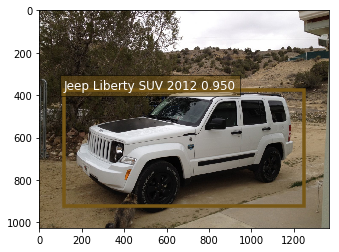

In [432]:
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.5

# Visualize the detections.
visualize_detection(file_name, result['prediction'], object_categories, threshold)

In [433]:
!wget https://images.autotrader.com/scaler/620/420/cms/content/articles/reviews/new/jeep/liberty/2012/169395.jpg

--2019-01-24 05:26:17--  https://images.autotrader.com/scaler/620/420/cms/content/articles/reviews/new/jeep/liberty/2012/169395.jpg
Resolving images.autotrader.com (images.autotrader.com)... 23.53.116.124
Connecting to images.autotrader.com (images.autotrader.com)|23.53.116.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47933 (47K) [image/jpeg]
Saving to: ‘169395.jpg’

169395.jpg          100%[===================>]  46.81K  --.-KB/s    in 0.002s  

2019-01-24 05:26:17 (23.0 MB/s) - ‘169395.jpg’ saved [47933/47933]



In [434]:
file_name = '169395.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

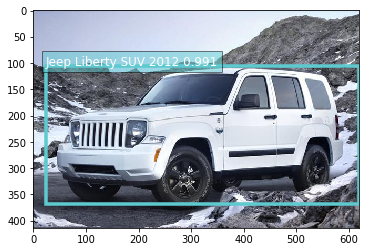

In [435]:
import json

object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
result = json.loads(results)
visualize_detection(file_name, result['prediction'], object_categories, threshold)